In [1]:
# импорт библиотек
!pip install scikit-learn -q
!pip install phik -q
!pip install shap -q
!pip install --upgrade scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, 
                             confusion_matrix, recall_score, precision_score, 
                             roc_auc_score, accuracy_score)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

hi

Описание задачи:

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

## Загрузка данных

In [2]:
# читаем исходные данные
print('\n')
df_file = pd.read_csv('market_file.csv', sep=',')
pd.set_option('display.max_columns', None)
print('Таблица df_file, которая содержит данные о поведении покупателя на сайте,' 
      'о коммуникациях с покупателем и его продуктовом поведении:')
display(df_file.head(5))
print('\n')

df_money = pd.read_csv('market_money.csv', sep=',')
pd.set_option('display.max_columns', None)
print('Таблица df_money с данными о выручке, которую получает магазин с покупателя,'
      'то есть сколько покупатель всего потратил за период взаимодействия с сайтом:')
display(df_money.head(5))
print('\n')

df_time = pd.read_csv('market_time.csv', sep=',')
pd.set_option('display.max_columns', None)
print('Таблица df_time с данными о времени (в минутах),'
      'которое покупатель провёл на сайте в течение периода:')
display(df_time.head(5))

df_money_seg = pd.read_csv('money.csv', sep=';')
pd.set_option('display.max_columns', None)
print('Таблица df_money_seg с данными о среднемесячной прибыли продавца за последние 3 месяца')
display(df_money_seg.head(5))




Таблица df_file, которая содержит данные о поведении покупателя на сайте,о коммуникациях с покупателем и его продуктовом поведении:


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2




Таблица df_money с данными о выручке, которую получает магазин с покупателя,то есть сколько покупатель всего потратил за период взаимодействия с сайтом:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6




Таблица df_time с данными о времени (в минутах),которое покупатель провёл на сайте в течение периода:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Таблица df_money_seg с данными о среднемесячной прибыли продавца за последние 3 месяца


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


## Предобработка данных

### Производим предобработку датафрейма df_file

In [3]:
# датафрейм df_file:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
print(df_file.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [4]:
df_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

В датафрейме df_file пропуски отсутствуют

In [5]:
# приведём имена столбцов к змеиному регистру
df_file = df_file.rename(columns={'Покупательская активность': 'Покупательская_активность', 'Тип сервиса': 'Тип_сервиса', 
                                'Разрешить сообщать': 'Разрешить_сообщать'})
display(df_file.head(1))

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5


In [6]:
# проверка на явные дубликаты
print('Количество явных дубликатов df_file: ', df_file.duplicated().sum())

Количество явных дубликатов df_file:  0


In [7]:
# поиск неявных дубликатов
all_columns = df_file.columns.tolist()
selected_columns = [all_columns[1], all_columns[2], all_columns[3], all_columns[8]]
for column in selected_columns:
    print(f'Столбец *{column}*:\n{df_file[column].value_counts()}\n')

Столбец *Покупательская_активность*:
Прежний уровень    802
Снизилась          498
Name: Покупательская_активность, dtype: int64

Столбец *Тип_сервиса*:
стандарт     914
премиум      376
стандартт     10
Name: Тип_сервиса, dtype: int64

Столбец *Разрешить_сообщать*:
да     962
нет    338
Name: Разрешить_сообщать, dtype: int64

Столбец *Популярная_категория*:
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64



Неявные дубликаты присутствуют в столбце *Тип сервиса*: стандарт и стандартт. Объединим в *стандарт*.

In [8]:
# заменяем
df_file['Тип_сервиса'].replace("стандартт", "стандарт", inplace=True)
# проверяем
df_file['Тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: Тип_сервиса, dtype: int64

### Производим предобработку датафрейма df_money

In [9]:
# датафрейм df_money::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
print(df_money.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


In [10]:
df_money.isna().sum()

id         0
Период     0
Выручка    0
dtype: int64

В датафрейме df_money пропуски отсутствуют

In [11]:
# проверка на явные дубликаты
print('Количество явных дубликатов df_money: ', df_money.duplicated().sum())

Количество явных дубликатов df_money:  0


In [12]:
# поиск неявных дубликатов
all_columns = df_money.columns.tolist()
selected_columns = [all_columns[1]]
for column in selected_columns:
    print(f'Столбец *{column}*:\n{df_money[column].value_counts()}\n')

Столбец *Период*:
текущий_месяц          1300
препредыдущий_месяц    1300
предыдущий_месяц       1300
Name: Период, dtype: int64



Неявные дубликаты отсутствуют.

### Производим предобработку датафрейма df_time

In [13]:
# датафрейм df_time:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

print(df_time.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


In [14]:
df_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

В датафрейме df_time пропуски отсутствуют

In [15]:
# проверка на явные дубликаты
print('Количество явных дубликатов df_time: ', df_time.duplicated().sum())

Количество явных дубликатов df_time:  0


In [16]:
# поиск неявных дубликатов
all_columns = df_time.columns.tolist()
selected_columns = [all_columns[1]]
for column in selected_columns:
    print(f'Столбец *{column}*:\n{df_time[column].value_counts()}\n')

Столбец *Период*:
предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64



Есть ошибка в значении колонки *Период*: предыдцщий_месяц. Исправим на *предыдущий_месяц*.

In [17]:
# заменяем
df_time['Период'].replace("предыдцщий_месяц", "предыдущий_месяц", inplace=True)
# проверяем
df_time['Период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: Период, dtype: int64

### Производим предобработку датафрейма df_money_seg 

In [18]:
# датафрейм df_money_seg:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

print(df_money_seg.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
None


In [19]:
df_money_seg.isna().sum()

id         0
Прибыль    0
dtype: int64

В датафрейме df_money_seg пропуски отсутствуют

In [20]:
# проверка на явные дубликаты
print('Количество явных дубликатов df_money_seg: ', df_money_seg.duplicated().sum())

Количество явных дубликатов df_money_seg:  0


In [21]:
# заменяем запятые на точки
for cell in ['Прибыль']:
    df_money_seg[cell] = df_money_seg[cell].str.replace(',', '.')
display(df_money_seg.head(5))  

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [22]:
# изменим тип данных в колонке "Прибыль" на float
df_money_seg['Прибыль'] = df_money_seg['Прибыль'].astype(float)
print(df_money_seg.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
None


В ходе предобработки был произведён поиск и устранение пропусков, явных и неявных дубликатов, приведение типа данных столбцов к корректному виду.

## Исследовательский анализ данных

### Анализ датафрейма df_file

#### Столбец 'Покупательская_активность'

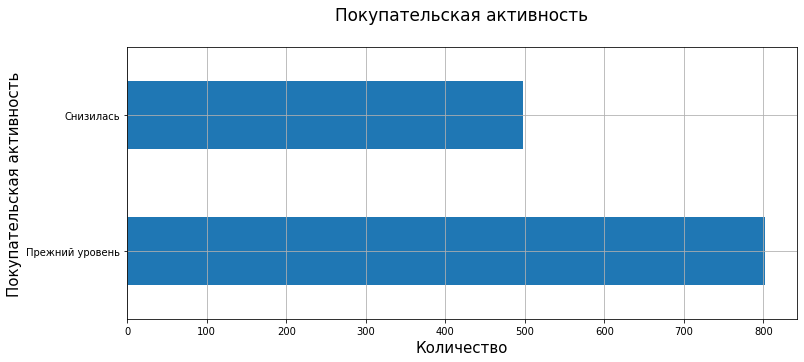

In [23]:
df_file['Покупательская_активность'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)

plt.xlabel('Количество', fontsize=15)
plt.ylabel('Покупательская активность', fontsize=15)
plt.title('Покупательская активность\n', fontsize=17);

#### Столбец 'Тип_сервиса'

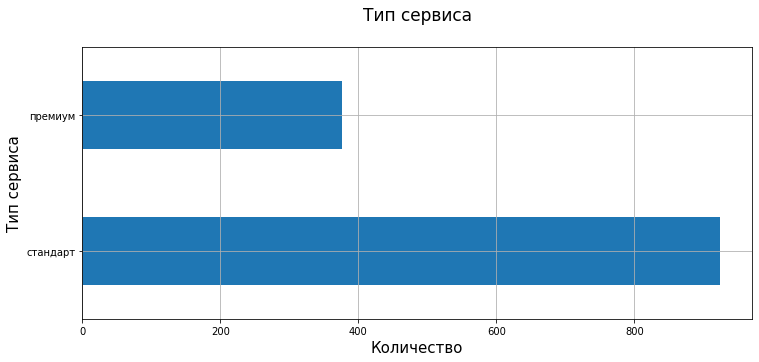

In [24]:
ax = df_file['Тип_сервиса'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
    
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Тип сервиса', fontsize=15)
plt.title('Тип сервиса\n', fontsize=17);

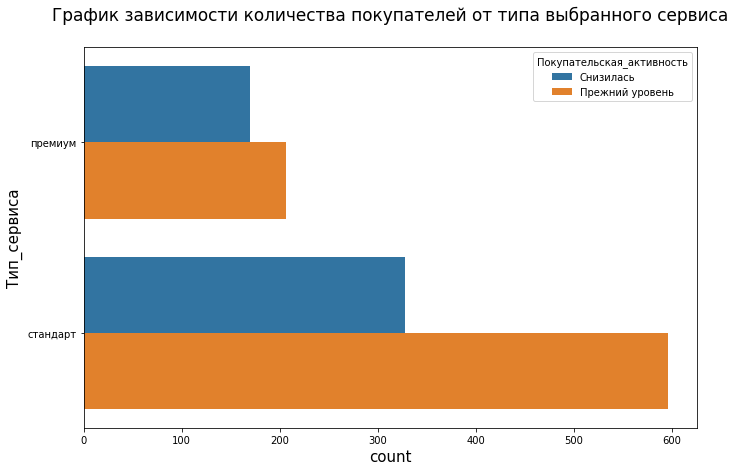

In [25]:
plt.figure(figsize=(11, 7))
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Тип сервиса', fontsize=15)
plt.title('График зависимости количества покупателей от типа выбранного сервиса\n', fontsize=17);
sns.countplot(data=df_file, y='Тип_сервиса', hue='Покупательская_активность', orient='h');

#### Столбец 'Разрешить_сообщать'

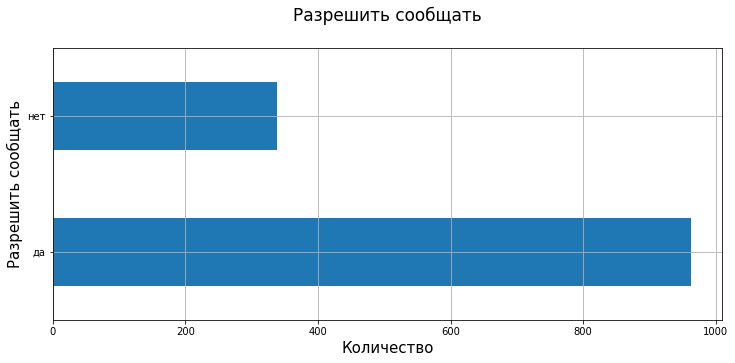

In [26]:
df_file['Разрешить_сообщать'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)

plt.xlabel('Количество', fontsize=15)
plt.ylabel('Разрешить сообщать', fontsize=15)
plt.title('Разрешить сообщать\n', fontsize=17);

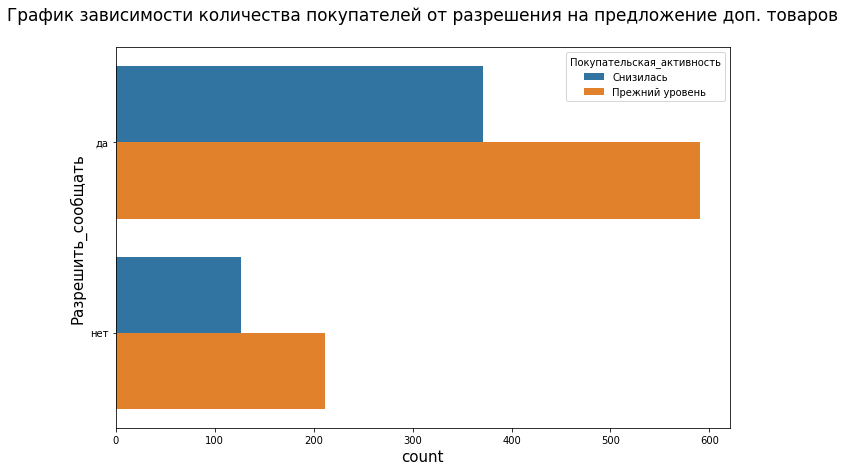

In [27]:
plt.figure(figsize=(11, 7))
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Разрешить сообщать', fontsize=15)
plt.title('График зависимости количества покупателей от разрешения на предложение доп. товаров\n', fontsize=17)
sns.countplot(data=df_file, y='Разрешить_сообщать', hue='Покупательская_активность', orient='h');

#### Столбец 'Маркет_актив_6_мес'

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: Маркет_актив_6_мес, dtype: float64

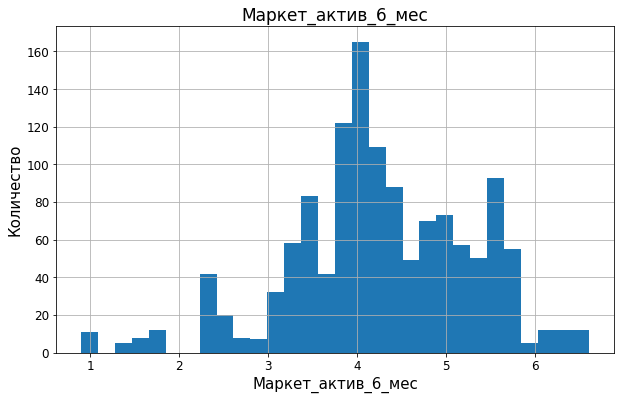

In [28]:
# гистограмма столбца Маркет_актив_6_мес
df_file['Маркет_актив_6_мес'].plot(kind = 'hist', bins=30, figsize = (10,6), fontsize = 12, grid=True)

plt.xlabel('Маркет_актив_6_мес', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('Маркет_актив_6_мес', fontsize=17)

df_file['Маркет_актив_6_мес'].describe()

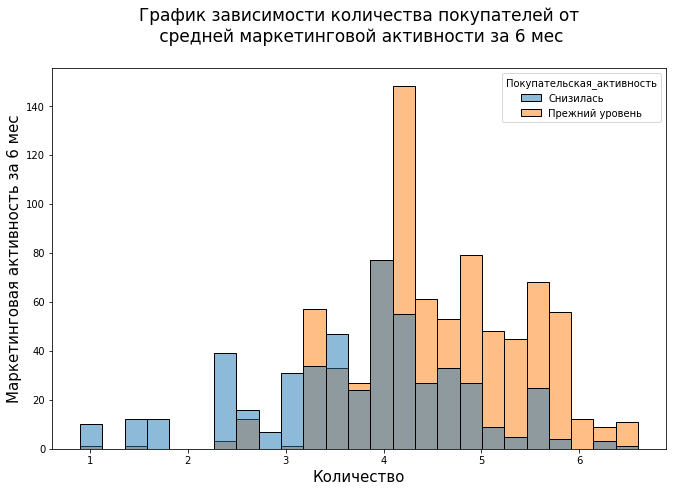

In [29]:
# нашёл на просторах и оч понравилась идея=)
plt.figure(figsize=(11, 7))
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Маркетинговая активность за 6 мес', fontsize=15)
plt.title('График зависимости количества покупателей от\n средней маркетинговой активности за 6 мес\n', fontsize=17);
sns.histplot(df_file, bins=25, hue='Покупательская_активность', x='Маркет_актив_6_мес');

Выбросов и аномалий нет.

#### Столбец 'Маркет_актив_тек_мес'

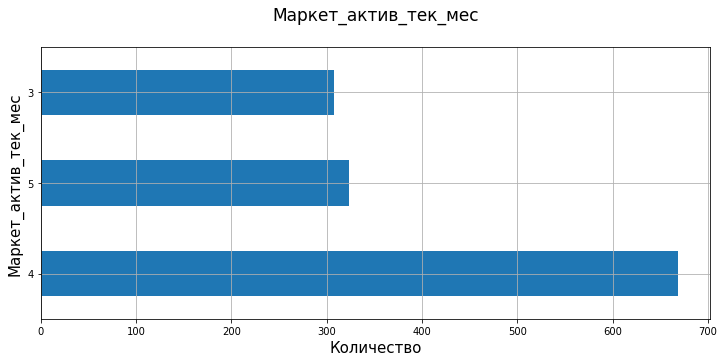

In [30]:
df_file['Маркет_актив_тек_мес'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Маркет_актив_тек_мес', fontsize=15)
plt.title('Маркет_актив_тек_мес\n', fontsize=17);

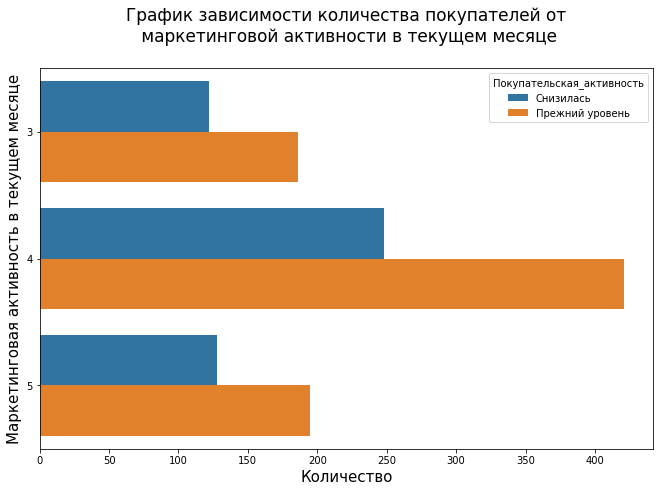

In [31]:
plt.figure(figsize=(11, 7))
plt.title('График зависимости количества покупателей от\n маркетинговой активности в текущем месяце\n', fontsize=17)
ax = sns.countplot(data=df_file, y='Маркет_актив_тек_мес', hue='Покупательская_активность', orient='h')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Маркетинговая активность в текущем месяце', fontsize=15) ;


#### Столбец 'Длительность'

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: Длительность, dtype: float64

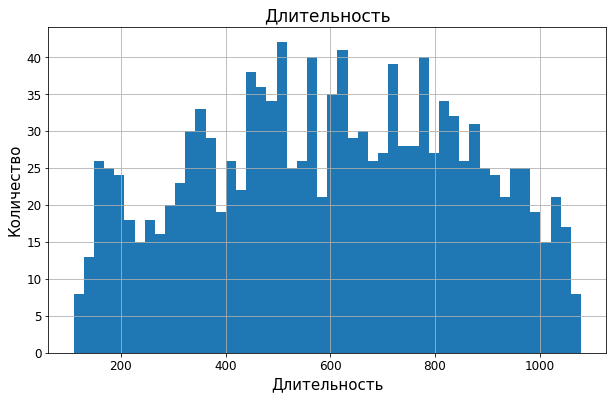

In [32]:
# гистограмма столбца Длительность
df_file['Длительность'].plot(kind = 'hist', bins=50, figsize = (10,6), fontsize = 12, grid=True);
plt.xlabel('Длительность', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('Длительность', fontsize=17)

df_file['Длительность'].describe()

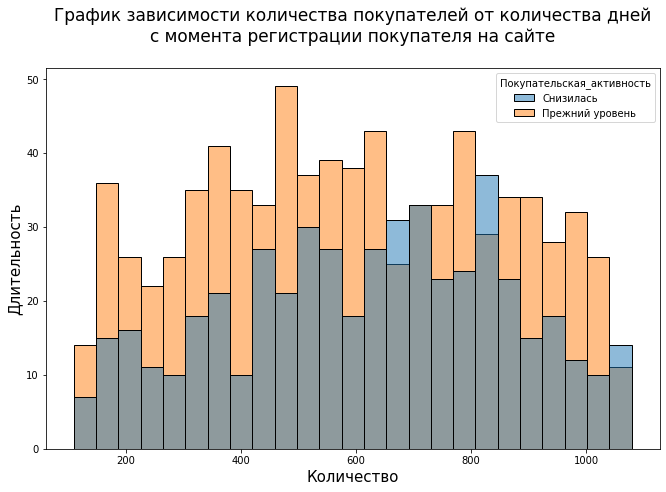

In [33]:
plt.figure(figsize=(11, 7))
plt.title('График зависимости количества покупателей от количества дней\n'
           'с момента регистрации покупателя на сайте\n', fontsize=17);
ax = sns.histplot(df_file, bins=25, hue='Покупательская_активность', x='Длительность')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Длительность', fontsize=15);

Выбросов и аномалий нет.

#### Столбец 'Акционные_покупки'

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: Акционные_покупки, dtype: float64

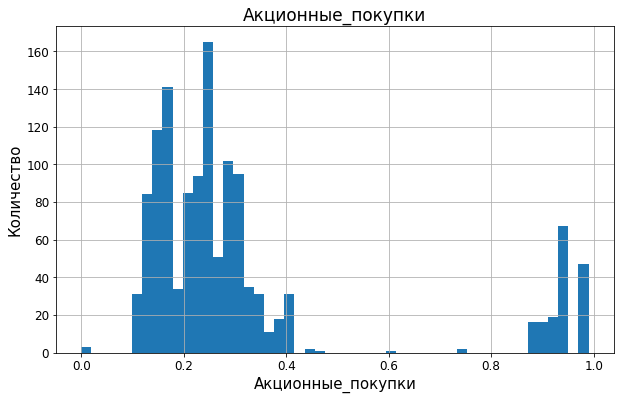

In [34]:
# гистограмма столбца Акционные_покупки
df_file['Акционные_покупки'].plot(kind = 'hist', bins=50, figsize = (10,6), fontsize = 12, grid=True)#range=(3.065, 3.09)
plt.xlabel('Акционные_покупки', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('Акционные_покупки', fontsize=17)

df_file['Акционные_покупки'].describe()

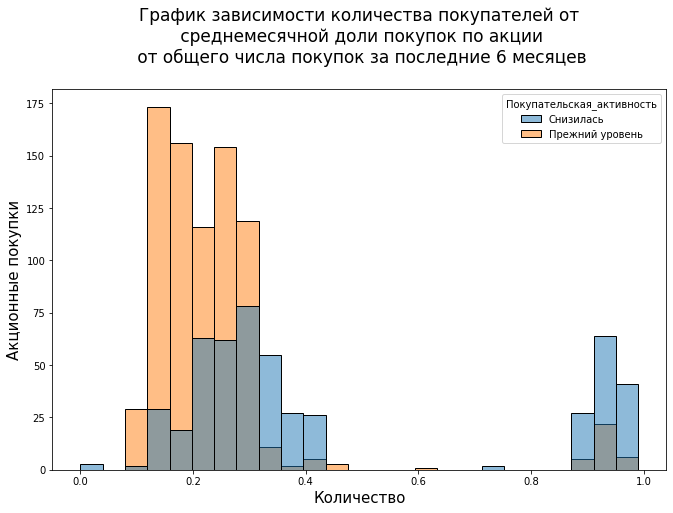

In [35]:
plt.figure(figsize=(11, 7))
plt.title('График зависимости количества покупателей от\n среднемесячной доли покупок по акции\n'
          ' от общего числа покупок за последние 6 месяцев\n', fontsize=17)
ax = sns.histplot(df_file, bins=25, hue='Покупательская_активность', x='Акционные_покупки')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Акционные покупки', fontsize=15);

Выбросов и аномалий нет.

#### Столбец 'Популярная_категория'

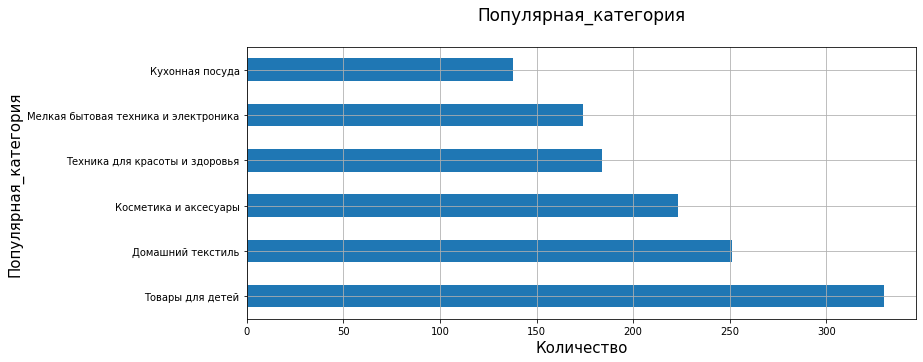

In [36]:
df_file['Популярная_категория'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Популярная_категория', fontsize=15)
plt.title('Популярная_категория\n', fontsize=17);

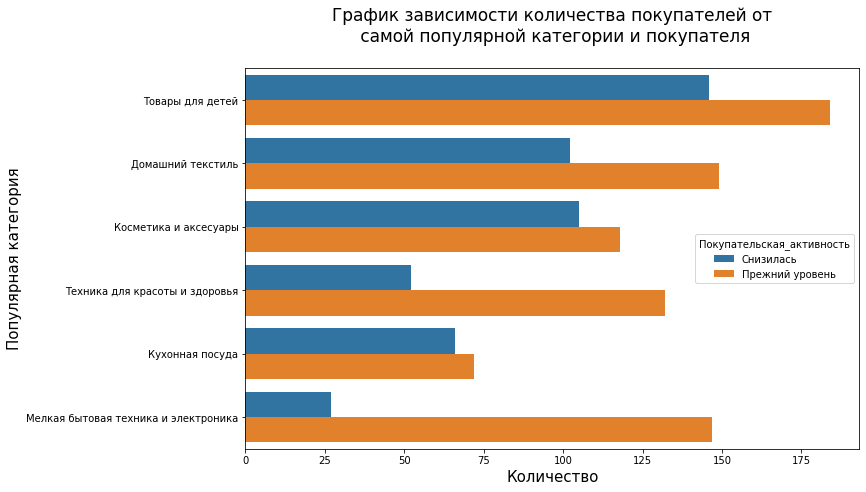

In [37]:
plt.figure(figsize=(11, 7))
plt.title('График зависимости количества покупателей от\n самой популярной категории и покупателя\n', fontsize=17);
ax = sns.countplot(data=df_file, y='Популярная_категория', hue='Покупательская_активность', orient='h')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Популярная категория', fontsize=15);

#### Столбец 'Средний_просмотр_категорий_за_визит'

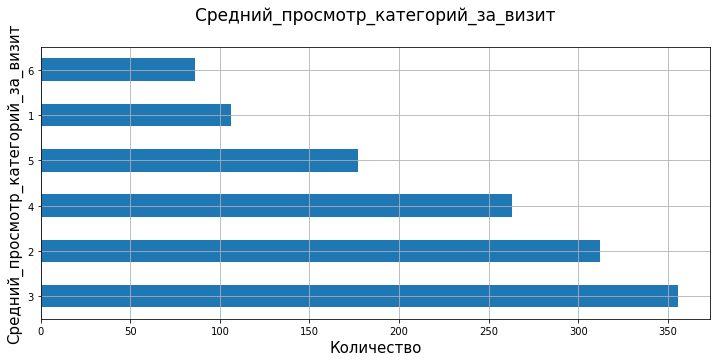

In [38]:
df_file['Средний_просмотр_категорий_за_визит'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Средний_просмотр_категорий_за_визит', fontsize=15)
plt.title('Средний_просмотр_категорий_за_визит\n', fontsize=17);

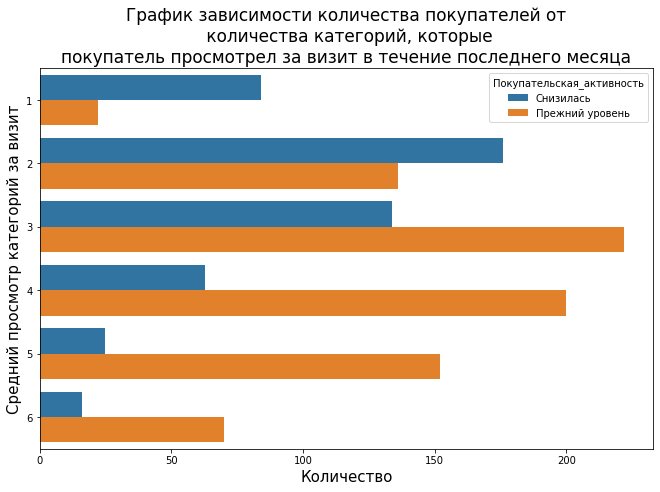

In [39]:
plt.figure(figsize=(11, 7))
plt.title('График зависимости количества покупателей от\n количества категорий, которые\n'
          'покупатель просмотрел за визит в течение последнего месяца', fontsize=17)
ax = sns.countplot(data=df_file, y='Средний_просмотр_категорий_за_визит', hue='Покупательская_активность', orient='h')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Средний просмотр категорий за визит', fontsize=15);

#### Столбец 'Неоплаченные_продукты_штук_квартал'

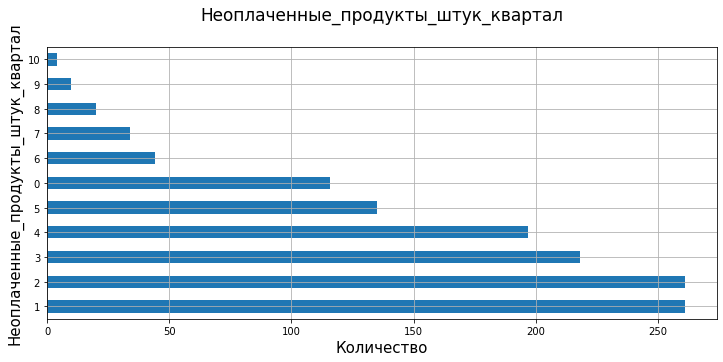

In [40]:
df_file['Неоплаченные_продукты_штук_квартал'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Неоплаченные_продукты_штук_квартал', fontsize=15)
plt.title('Неоплаченные_продукты_штук_квартал\n', fontsize=17);

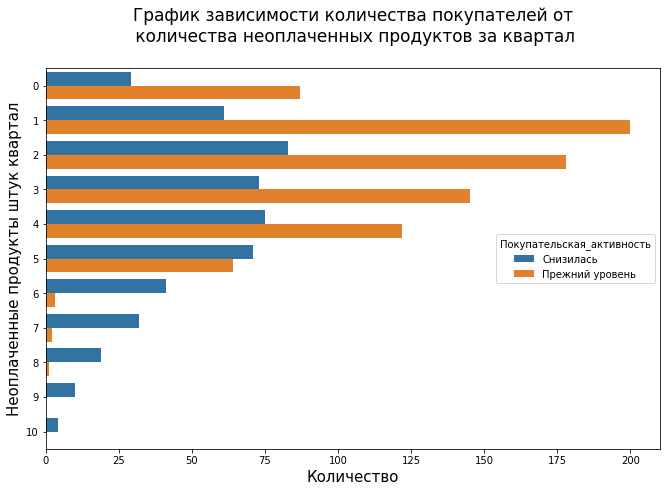

In [41]:
plt.figure(figsize=(11, 7))
ax = sns.countplot(data=df_file, y='Неоплаченные_продукты_штук_квартал', hue='Покупательская_активность', orient='h')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Неоплаченные продукты штук квартал', fontsize=15)
ax.set_title('График зависимости количества покупателей от\n количества неоплаченных продуктов за квартал\n', fontsize=17);

#### Столбец 'Ошибка_сервиса'

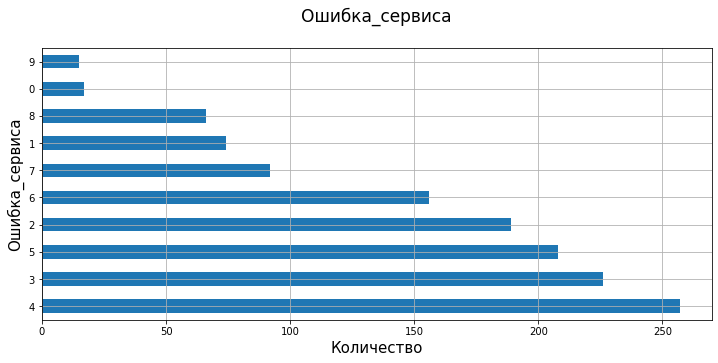

In [42]:
df_file['Ошибка_сервиса'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Ошибка_сервиса', fontsize=15)
plt.title('Ошибка_сервиса\n', fontsize=17);

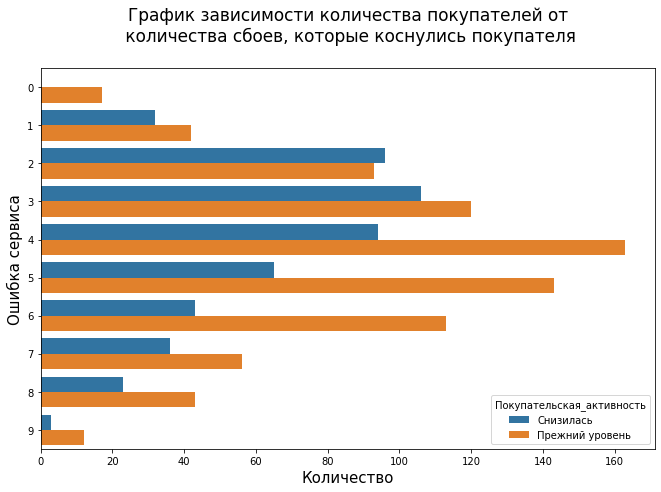

In [43]:
plt.figure(figsize=(11, 7))
ax = sns.countplot(data=df_file, y='Ошибка_сервиса', hue='Покупательская_активность', orient='h')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Ошибка сервиса', fontsize=15)
ax.set_title('График зависимости количества покупателей от\n количества сбоев, которые коснулись покупателя\n', fontsize=17);

#### Столбец 'Страниц_за_визит'

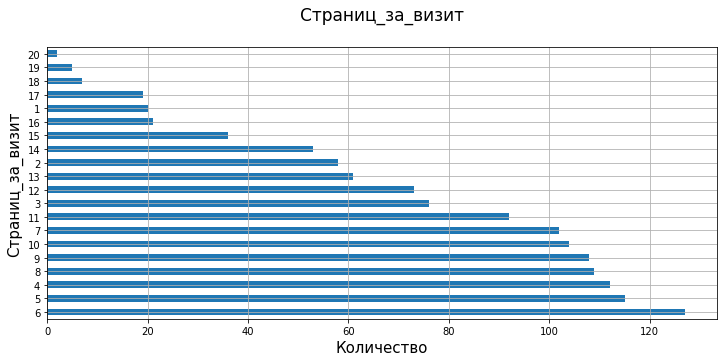

In [44]:
df_file['Страниц_за_визит'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Страниц_за_визит', fontsize=15)
plt.title('Страниц_за_визит\n', fontsize=17);

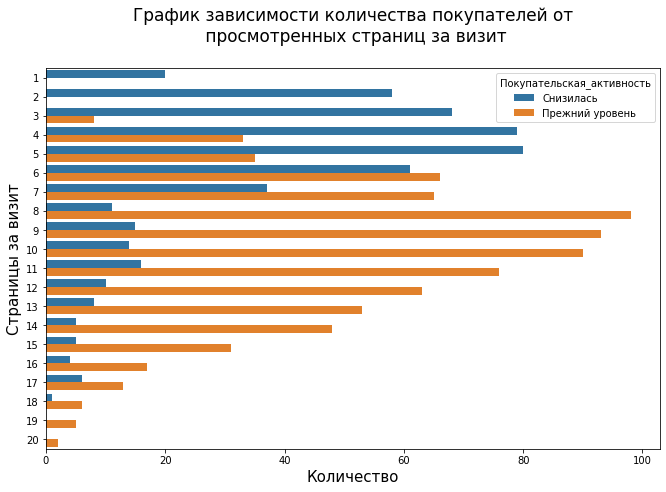

In [45]:
plt.figure(figsize=(11, 7))
ax = sns.countplot(data=df_file, y='Страниц_за_визит', hue='Покупательская_активность', orient='h')
ax.set_xlabel('Количество', fontsize=15) 
ax.set_ylabel('Страницы за визит', fontsize=15)
ax.set_title('График зависимости количества покупателей от\n просмотренных страниц за визит\n', fontsize=17);

### Анализ датафрейма df_money

#### Столбец 'Период'

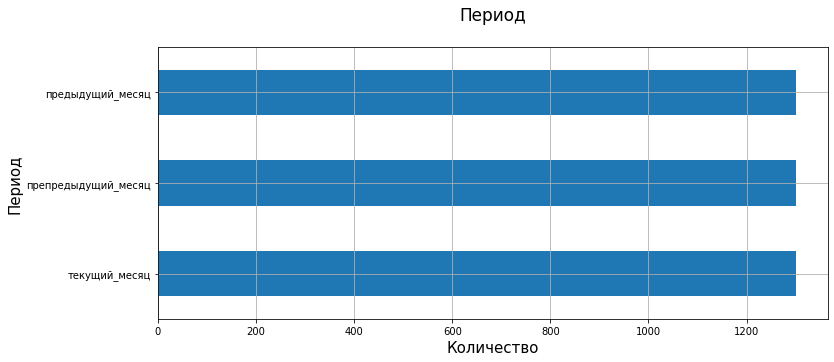

In [46]:
df_money['Период'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Период', fontsize=15)
plt.title('Период\n', fontsize=17);

#### Столбец 'Выручка'

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: Выручка, dtype: float64

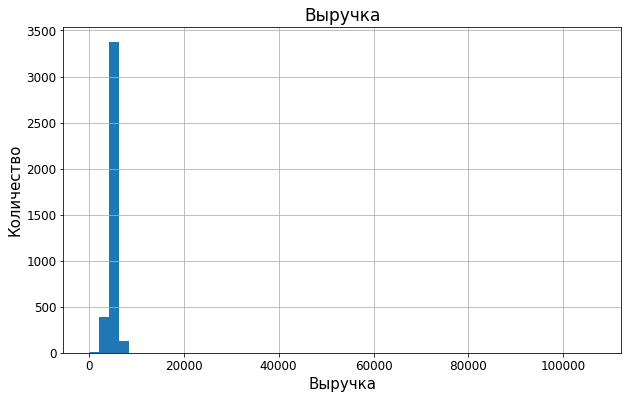

In [47]:
# гистограмма столбца Выручка
df_money['Выручка'].plot(kind = 'hist', bins=50, figsize = (10,6), fontsize = 12, grid=True)
plt.xlabel('Выручка', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('Выручка', fontsize=17)

df_money['Выручка'].describe()

In [48]:
print(f'Размерность до удаления выбросов: {df_money.shape}')

Размерность до удаления выбросов: (3900, 3)


In [49]:
# удалим все значения менее нуля и более 10000
df_money = df_money.query('Выручка < 10000')
# проверяем размерность таблицы после удаления
print(f'Размерность после удаления выбросов: {df_money.shape}')

Размерность после удаления выбросов: (3899, 3)


In [50]:
df_money['Выручка'].describe()

count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: Выручка, dtype: float64

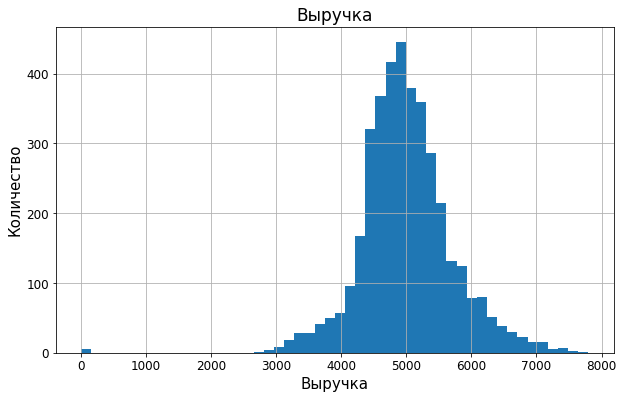

In [51]:
# гистограмма столбца Выручка после удаления выброса
df_money['Выручка'].plot(kind = 'hist', bins=50, figsize = (10,6), fontsize = 12, grid=True)
plt.xlabel('Выручка', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('Выручка', fontsize=17);

### Анализ датафрейма df_time

#### Столбец 'Период'

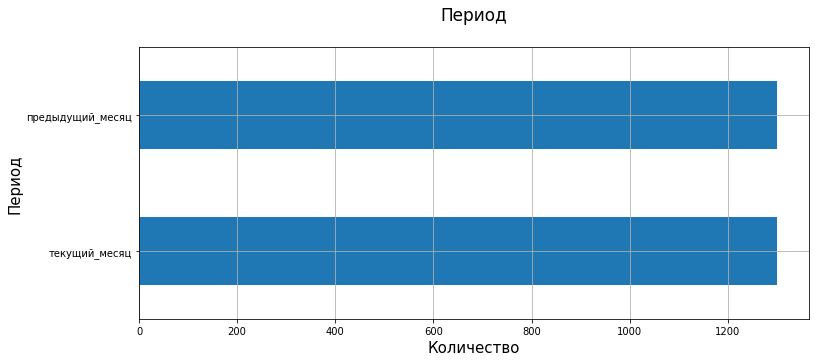

In [52]:
df_time['Период'].value_counts().plot(kind="barh", rot=0, fontsize=10, figsize = (12,5), grid=True)
plt.xlabel('Количество', fontsize=15)
plt.ylabel('Период', fontsize=15)
plt.title('Период\n', fontsize=17);

#### Столбец 'минут'

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

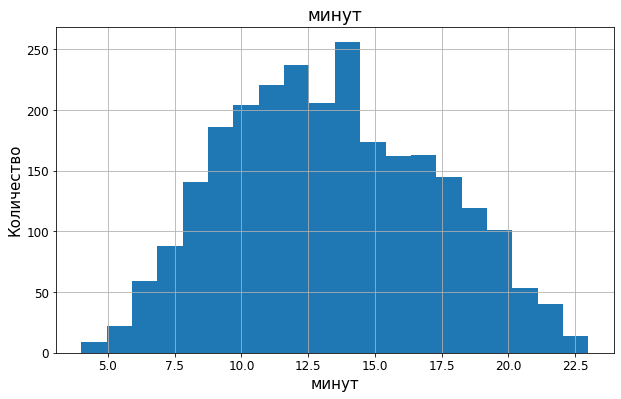

In [53]:
# гистограмма столбца Выручка
df_time['минут'].plot(kind = 'hist', bins=20, figsize = (10,6), fontsize = 12, grid=True)
plt.xlabel('минут', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('минут', fontsize=17)

df_time['минут'].describe()

Датафрейм df_file, содержащий данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
-  **Тип сервиса** - более трети покупателей со снизившейся активностью. Об этом стоит задуматься и начать принимать меры по сохранению активности
- **Тип сервиса** - есть куда стремиться и мотивировать покупателей пользоваться премиум сервисом, соотношение примерно 1 к 2 не в пользу премиума, разрыв между сохранившейся и снизившейся активностью в пользу сохранившейся увеличен в "стандарте"
- **Разрешить сообщать** - здесь всё хорошо, большинство клиентов обоих категорий разрешают присылать дополнительные предложения о товаре
- **Маркет актив 6 мес** - наиибольшее количество покупателей с маркетинговой активностью - 4 за полгода, явный пик у категории с сохранившейся активностью; маркетинг влияет на активность
- **Маркет актив тек мес** - тоже в лидерах значение "4", в целом соотношения сохраняются вне зависимости от активности
- **Длительность** - после примерно двух лет с момента регистрации покупательская активность иногда смещается в сторону снижения
- **Акционные покупки** - налицо тяготение к акционным покупкам у группы со снизевшейся активностью
- **Популярная категория** - самая популярная категория - ***товары для детей***, наименее популярная - ***кухонная посуда***. Наибольший разрыв в категории "мелкая бытовая техника и электроника", где превалируют клиенты с сохранившимся уровнем. Может быть, эта техника чаще всего ломается, требует замены и пользователю приходится находиться в категории сохранивших активность. Такая же ситуация с техникой для красоты и здоровья. А вот посуда служит долго, и категории здась примерно равны, посуду неспешно покупают обе категории.
- **Средний просмотр категорий за визит** - лидирует количество "3 просмотра". Вероятно, остальных пользователей надо подтягивать к этому значению. Наименьший разрыв при просмотре 2-3-х категорий за визит.
- **Неоплаченные продукты штук квартал** - лидируют значения 1 и 2; полагаю, надо стремиться к нулю (хотя это и не достижимо), напоминая покупателю о товарах в корзине, либо предлагая скидки на эти товары. Покупатели со снизившейся активностью склонны хранить в корзине более 6-ти товаров. Всё закономерно - хотят, но не покупают. Причины у всех разные.
- **Ошибка сервиса** - присутствует много ошибок, почти нет пользователей, которые не сталкивались со сбоями; надо исправлять приложение. При маленьком количестве ошибок высока доля "снизившихся"; далее - наоборот. Тяжело предположить, почему так происходит.
- **Страниц за визит** - середина - 6 страниц. Пользователи с просмотром 1-2-х (3-4-х в меньшей степени) страниц доминируют в категории со снизившейся активностью. Налицо недостаток вовлечённости. Плохой интерфейс, дизайн, высокие цены?

Датафрейм df_money, содержащий данные о выручке, которую получает магазин с покупателя:
- **Период** - далее данные в столбце будут конвертированы в новые колонки
- **Выручка** - присутствует аномалия 106862.2, которая удалена; среднее значение выручки - около 5000  

Датафрейм df_time, с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
- **Период** - далее данные в столбце будут конвертированы в новые колонки
- **минут** - наибольшее количество покупателей проводят в сервисе от 12 до 15 минут

### Выбор клиентов с покупательской активностью не менее трёх месяцев

Отберём клиентов на основе таблицы money, а именно выручки за препредыдущий месяц, текущий месяц, предыдущий месяц. Исключим из таблицы тех клиентов, выручка от которых равнялась нули во всех трёх месяцах.

In [54]:
# освежим таблицу в памяти
display(df_money.head(15))

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
8,215350,предыдущий_месяц,5457.5
9,215351,текущий_месяц,6610.4


In [55]:
# узнаем типы данных в столбца дф. df_money
df_money.dtypes

id           int64
Период      object
Выручка    float64
dtype: object

In [56]:
# построение сводной таблицы по дф. df_money
df_money_pivot = df_money.pivot_table(index=['id'], columns='Период', values='Выручка').reset_index()#, aggfunc='sum'
df_money_pivot.columns = ['id', 'траты_предыдущий_месяц', 'траты_препредыдущий_месяц', 'траты_текущий_месяц']
display(df_money_pivot.head(15))

,id,траты_предыдущий_месяц,траты_препредыдущий_месяц,траты_текущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
5,215353,4738.5,5124.0,5388.5
6,215354,5685.0,4503.0,5869.6
7,215355,3263.0,4749.0,3772.6
8,215356,4146.5,4433.0,4566.4
9,215357,0.0,0.0,5986.3


In [57]:
df_money_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1300 non-null   int64  
 1   траты_предыдущий_месяц     1300 non-null   float64
 2   траты_препредыдущий_месяц  1300 non-null   float64
 3   траты_текущий_месяц        1299 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 40.8 KB


In [58]:
# найдём строку с NaN
df_money_pivot[df_money_pivot['траты_текущий_месяц'].isnull() == True]

,id,траты_предыдущий_месяц,траты_препредыдущий_месяц,траты_текущий_месяц
32,215380,6077.0,5051.0,NaN


In [59]:
# удалим эту строку
df_money_pivot = df_money_pivot.dropna(subset=['траты_текущий_месяц'])
df_money_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         1299 non-null   int64  
 1   траты_предыдущий_месяц     1299 non-null   float64
 2   траты_препредыдущий_месяц  1299 non-null   float64
 3   траты_текущий_месяц        1299 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.7 KB


In [60]:
# проверяем наличие клиентов с покупательской активностью не менее трёх месяцев
df_money_pivot_none_active = df_money_pivot.query('траты_предыдущий_месяц == 0 | траты_препредыдущий_месяц == 0 | траты_текущий_месяц == 0')
df_money_pivot_none_active

,id,траты_предыдущий_месяц,траты_препредыдущий_месяц,траты_текущий_месяц
0,215348,0.0,0.0,3293.1
9,215357,0.0,0.0,5986.3
11,215359,0.0,0.0,4735.0


In [61]:
# удалим их
df_money_pivot = df_money_pivot.query('траты_предыдущий_месяц != 0 & траты_препредыдущий_месяц != 0 & траты_текущий_месяц != 0')
# проверим
df_money_pivot.query('траты_предыдущий_месяц == 0 | траты_препредыдущий_месяц == 0 | траты_текущий_месяц == 0').shape

(0, 4)

Всё ок, клиентов, которые ничего не покупали хотя бы в один из трёх месяцев, не осталось.

In [62]:
display(df_money_pivot.head(5))

,id,траты_предыдущий_месяц,траты_препредыдущий_месяц,траты_текущий_месяц
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5
5,215353,4738.5,5124.0,5388.5


In [63]:
# построение сводной таблицы по дф. df_time
df_time_pivot = df_time.pivot_table(index=['id'], columns='Период', values='минут').reset_index()#, aggfunc='sum'
df_time_pivot.columns = ['id', 'время_предыдущий_месяц', 'время_текущий_месяц']
display(df_time_pivot.head(15))

,id,время_предыдущий_месяц,время_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
5,215353,10,10
6,215354,11,12
7,215355,12,10
8,215356,6,7
9,215357,12,6


In [64]:
df_time_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   id                      1300 non-null   int64
 1   время_предыдущий_месяц  1300 non-null   int64
 2   время_текущий_месяц     1300 non-null   int64
dtypes: int64(3)
memory usage: 30.6 KB


### Выводы по исследовательскому анализу данных

В представленных таблицах содержатся данные о поведении покупателя на сайте, времени проведённом покупателем в сервисе и выручке от покупателя.

Данные рассмотрены как обобщённо, так и в разрезе двух категорий: "Прежний уровень" покупательской способности и покупательская способность "Снизилась".

Покупатели со снизившейся активностью просматривают меньше страниц за визит, совершают больше акционных покупок и иногда дольше зависают в сервисе, сильнее негативно реагируют на небольшое количество сбоев. Вероятно, такие покупатели более требовательны к дизайну, скорости работы сервиса, их легко отвлечь от покупки, а, главное, более чувствительны к ценообразованию. Такой группе следует предлагать больше акционных товаров, быстрее доводить их до оплаты, напоминать о товарах в корзине. Ну и, безотностительно категории, следует работать над минимизацией ошибок в сервисе.

## Объединение таблиц market_file.csv , market_money.csv, market_time.csv

In [65]:
# объядиняем датафреймы методом merge
df_file_money = pd.merge(df_file, df_money_pivot, on='id', how='left')
df_total = pd.merge(df_file_money, df_time_pivot, on='id', how='left')
display(df_total.head(5))
df_total.info()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_препредыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская_активность            1300 non-null   object 
 2   Тип_сервиса                          1300 non-null   object 
 3   Разрешить_сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [66]:
df_total.isnull().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
траты_предыдущий_месяц                 4
траты_препредыдущий_месяц              4
траты_текущий_месяц                    4
время_предыдущий_месяц                 0
время_текущий_месяц                    0
dtype: int64

In [67]:
# найдём строки с NaN и удалим
display(df_total[df_total.isna().any(axis=1)])
df_total = df_total.dropna()
df_total.info()

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_препредыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,NaN,NaN,NaN,12,6
11,215359,Снизилась,стандарт,да,4.6,5,110,0.00,Домашний текстиль,4,2,4,2,NaN,NaN,NaN,13,11
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,NaN,NaN,NaN,12,14


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Разрешить_сообщать                   1296 non-null   object 
 4   Маркет_актив_6_мес                   1296 non-null   float64
 5   Маркет_актив_тек_мес                 1296 non-null   int64  
 6   Длительность                         1296 non-null   int64  
 7   Акционные_покупки                    1296 non-null   float64
 8   Популярная_категория                 1296 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  Ошибка_сервиса                

In [68]:
df_total.isnull().sum()

id                                     0
Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
траты_предыдущий_месяц                 0
траты_препредыдущий_месяц              0
траты_текущий_месяц                    0
время_предыдущий_месяц                 0
время_текущий_месяц                    0
dtype: int64

##  Корреляционный анализ

In [69]:
#display(df_total.head(1))

# построение корреляционной матрицы с помощью коэффициента корреляции Фи
df_total_phik = df_total[df_total.columns.tolist()[1:]]
corr_matrix_df_total = df_total_phik.phik_matrix(interval_cols = ['Маркет_актив_6_мес', 
                                                                  'Длительность', 
                                                                  'Акционные_покупки',
                                                                  'траты_предыдущий_месяц',
                                                                  'траты_текущий_месяц',
                                                                  'время_предыдущий_месяц',
                                                                  'время_текущий_месяц'
                                                                 ])
display(corr_matrix_df_total)

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_препредыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
Покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.405041,0.224154,0.747331,0.224638,0.429283,0.197213,0.685138,0.576770
Тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.113015,0.079515,0.087776,0.000000,0.323045,0.124216,0.131814,0.000000
Разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.162524,0.021839,0.097094,0.080842,0.316196,0.060907,0.038387,0.000000
Маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.217731,0.142401,0.376035,0.155476,0.562946,0.039795,0.363950,0.330601
Маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.142887,0.116946,0.000000,0.051824,0.320357,0.000000,0.107945,0.061410
Длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.128222,0.175608,0.128089,0.125572,0.419332,0.147048,0.026448,0.101481
Акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.246665,0.000000,0.350714,0.060733,0.611785,0.071094,0.262324,0.250558
Популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.254746,0.000000,0.177637,0.252097,0.242388,0.237240,0.195233,0.089883
Средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.334927,0.070315,0.293781,0.098440,0.000000,0.092597,0.159837,0.182568
Неоплаченные_продукты_штук_квартал,0.405041,0.113015,0.162524,0.217731,0.142887,0.128222,0.246665,0.254746,0.334927,1.000000,0.000000,0.310843,0.193536,0.612363,0.166017,0.197933,0.168998


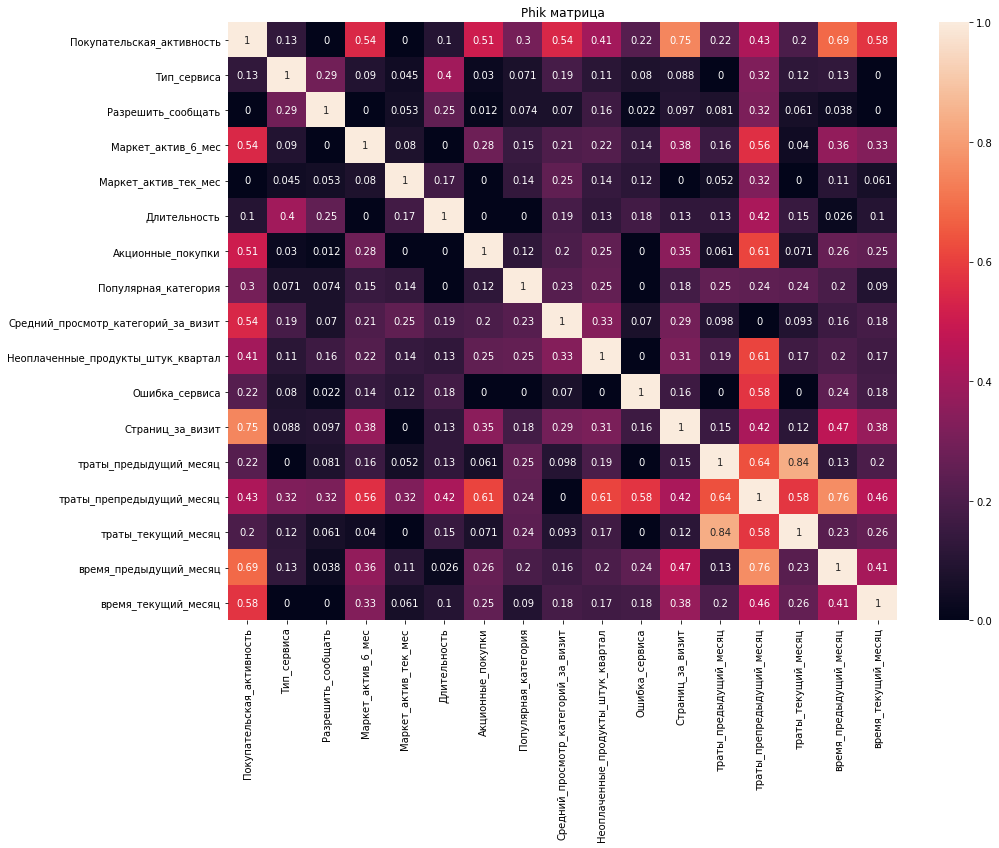

In [70]:
# построение тепловой карты
plt.figure(figsize=(15,11))
sns.heatmap(corr_matrix_df_total, annot=True)
plt.title('Phik матрица')
plt.show();

In [71]:
# список признаков с высокой корреляцией (удилим только признак "траты_препредыдущий_месяц")
# и наименее полезных признаков
columns_to_drop = ['траты_препредыдущий_месяц','Разрешить_сообщать','Маркет_актив_тек_мес']

# удаляем
df_total = df_total.drop(columns_to_drop, axis=1)

display(df_total.head(1))

,id,Покупательская_активность,Тип_сервиса,Маркет_актив_6_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
1,215349,Снизилась,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4971.6,12,10


##  Использование пайплайнов

In [72]:
display(df_total.head(10))

,id,Покупательская_активность,Тип_сервиса,Маркет_актив_6_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
1,215349,Снизилась,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4971.6,12,10
2,215350,Снизилась,стандарт,4.9,539,0.14,Домашний текстиль,5,2,1,5,5457.5,5058.4,8,13
3,215351,Снизилась,стандарт,3.2,896,0.99,Товары для детей,5,0,6,4,6158.0,6610.4,11,13
4,215352,Снизилась,стандарт,5.1,1064,0.94,Товары для детей,3,2,3,2,5807.5,5872.5,8,11
5,215353,Снизилась,стандарт,3.3,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5388.5,10,10
6,215354,Снизилась,стандарт,5.1,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,5869.6,11,12
7,215355,Снизилась,стандарт,4.7,284,0.17,Товары для детей,5,1,6,4,3263.0,3772.6,12,10
8,215356,Снизилась,стандарт,4.2,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4566.4,6,7
10,215358,Снизилась,стандарт,4.7,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4209.5,14,10
12,215360,Снизилась,премиум,3.9,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5834.9,9,6


In [73]:
# на всякий случай оставил работающий код
'''
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_total.drop(['Покупательская_активность', 'id'], axis=1),
    df_total['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_total['Покупательская_активность'])

# создаём списки с названиями признаков
ohe_columns = ['Тип_сервиса', 'Популярная_категория']
num_columns = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',
               'траты_предыдущий_месяц', 'траты_текущий_месяц', 'время_предыдущий_месяц', 'время_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore'))#, sparse=False
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': range(1, 5),
        'models__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'models__degree': [2, 3, 4, 5],  # Только для kernel='poly'
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

# Извлекаем лучшую модель
best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)
'''

# с исправлениями по твоим комментариям
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_total.drop(['Покупательская_активность', 'id'], axis=1),
    df_total['Покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_total['Покупательская_активность'])

# создаём списки с названиями признаков
ohe_columns = ['Популярная_категория']
ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',
               'траты_предыдущий_месяц', 'траты_текущий_месяц', 'время_предыдущий_месяц', 'время_текущий_месяц']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)


# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': range(1, 5),
        'models__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'models__degree': [2, 3, 4, 5],  # Только для kernel='poly'
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

# Извлекаем лучшую модель
best_model = randomized_search.best_estimator_

print('Лучшая модель и её параметры:\n\n', best_model)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent'...
    

In [74]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.9173239493588967


In [75]:
print(f'Параметры лучшей модели: {randomized_search.best_params_}')

Параметры лучшей модели: {'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}


## Анализ важности признаков

### Оценка важности признаков для лучшей модели и построение графика важности с помощью метода SHAP

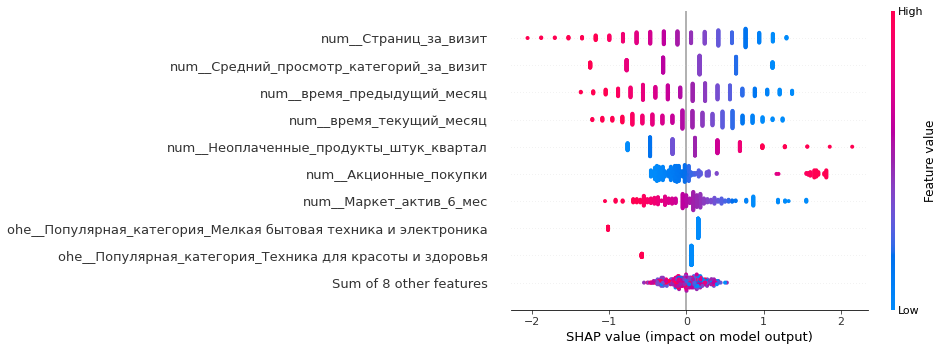

In [76]:
X_train_preprocessed = best_model.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = best_model.named_steps['preprocessor'].transform(X_test)

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

explainer = shap.Explainer(best_model.named_steps['models'], X_train_preprocessed, feature_names=feature_names)

shap_values = explainer(X_test_preprocessed)

shap.plots.beeswarm(shap_values)

In [77]:
# выясним какой целевой признак соответствует классу 1, а какой — классу 0
print(np.unique(y_train))

['Прежний уровень' 'Снизилась']


***Итого:*** 'Прежний уровень' - класс 0, 'Снизилась' - класс 1

### Выводы о значимости признаков:

Наиболее значимые признаки в порядке убывания значимости: 
- ***Страниц за визит*** - низкие значения этого признака увеличивают вероятность отнесения к классу 1 (покупательская способность 'Снизилась') и, наоборот, высокие значения увеличивают вероятность отнесения к классу 0 ('Прежний уровень' покупательской способности)
- ***Средний просмотр категорий за визит*** - низкие значения - к классу 1 , высокие значения - к классу 0 
- ***время предыдущий месяц - низкие значения*** - низкие значения к классу 1 , высокие значения - к классу 0 
- ***время текущий месяц - низкие значения*** - низкие значения к классу 1 , высокие значения - к классу 0 
- ***Неоплаченные продукты штук квартал*** - высокие значения - к классу 1, низкие значения - к классу 0
- ***Акционные покупки - высокие значения*** - высокие значения к классу 1, низкие значения - к классу 0
- ***Маркет актив 6 мес*** - низкие значения - низкие значения к классу 1 , высокие значения - к классу 0 
- ***Популярная категория Мелкая бытовая техника и электроника*** - низкие значения - к классу 1 , высокие значения - к классу 0 
- ***Популярная категория Техника для красоты и здоровья*** - низкие значения - к классу 1 , высокие значения - к классу 0 
- ***Оставшиеся 10 категорий суммарно*** - высокие значения - к классу 1, низкие значения - к классу 0

Данные говорят о том, что для увеличения в будущем вероятности сохранения покупательской способности клиента его необходимо "задержать" на сайте и увеличить маркетинговую активность.

## Сегментация покупателей

### Добавим в исходные данные вероятность снижения покупательской способности

In [78]:
X_combined = pd.concat([X_train, X_test])
y_combined = pd.concat([y_train, y_test])

In [79]:
y_combined_pred = randomized_search.predict(X_combined)
predictions_df = pd.DataFrame(y_combined_pred, columns=["прогноз"])

In [80]:
y_combined_prob_class1 = randomized_search.predict_proba(X_combined)[:, 1]
prob_class1_df = pd.DataFrame(y_combined_prob_class1, columns=["вероятность_снижения"])

In [81]:
df_total['прогноз'] = predictions_df
df_total['вероятность_снижения'] = prob_class1_df
df_total.head()

,id,Покупательская_активность,Тип_сервиса,Маркет_актив_6_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прогноз,вероятность_снижения
1,215349,Снизилась,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4971.6,12,10,Снизилась,0.659147
2,215350,Снизилась,стандарт,4.9,539,0.14,Домашний текстиль,5,2,1,5,5457.5,5058.4,8,13,Прежний уровень,0.057305
3,215351,Снизилась,стандарт,3.2,896,0.99,Товары для детей,5,0,6,4,6158.0,6610.4,11,13,Снизилась,0.797565
4,215352,Снизилась,стандарт,5.1,1064,0.94,Товары для детей,3,2,3,2,5807.5,5872.5,8,11,Снизилась,0.811114
5,215353,Снизилась,стандарт,3.3,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5388.5,10,10,Прежний уровень,0.012416


### Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей

In [82]:
# добавим к исходным данным таблицу df_money_seg
df_total = df_total.merge(df_money_seg, on='id', how='left')
display(df_total.head(5))
print(df_total.info())

,id,Покупательская_активность,Тип_сервиса,Маркет_актив_6_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прогноз,вероятность_снижения,Прибыль
0,215349,Снизилась,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4971.6,12,10,Снизилась,0.659147,4.16
1,215350,Снизилась,стандарт,4.9,539,0.14,Домашний текстиль,5,2,1,5,5457.5,5058.4,8,13,Прежний уровень,0.057305,3.13
2,215351,Снизилась,стандарт,3.2,896,0.99,Товары для детей,5,0,6,4,6158.0,6610.4,11,13,Снизилась,0.797565,4.87
3,215352,Снизилась,стандарт,5.1,1064,0.94,Товары для детей,3,2,3,2,5807.5,5872.5,8,11,Снизилась,0.811114,4.21
4,215353,Снизилась,стандарт,3.3,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5388.5,10,10,Прежний уровень,0.012416,3.95


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   Покупательская_активность            1296 non-null   object 
 2   Тип_сервиса                          1296 non-null   object 
 3   Маркет_актив_6_мес                   1296 non-null   float64
 4   Длительность                         1296 non-null   int64  
 5   Акционные_покупки                    1296 non-null   float64
 6   Популярная_категория                 1296 non-null   object 
 7   Средний_просмотр_категорий_за_визит  1296 non-null   int64  
 8   Неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 9   Ошибка_сервиса                       1296 non-null   int64  
 10  Страниц_за_визит                     1296 non-null   int64  
 11  траты_предыдущий_месяц        

In [83]:
# удалим строки с нулевыми значениями
df_total = df_total.dropna()
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1292 entries, 0 to 1291
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1292 non-null   int64  
 1   Покупательская_активность            1292 non-null   object 
 2   Тип_сервиса                          1292 non-null   object 
 3   Маркет_актив_6_мес                   1292 non-null   float64
 4   Длительность                         1292 non-null   int64  
 5   Акционные_покупки                    1292 non-null   float64
 6   Популярная_категория                 1292 non-null   object 
 7   Средний_просмотр_категорий_за_визит  1292 non-null   int64  
 8   Неоплаченные_продукты_штук_квартал   1292 non-null   int64  
 9   Ошибка_сервиса                       1292 non-null   int64  
 10  Страниц_за_визит                     1292 non-null   int64  
 11  траты_предыдущий_месяц        

Будем исследовать сегмент "Группа клиентов с высокой вероятностью снижения активности и высокой выручкой".

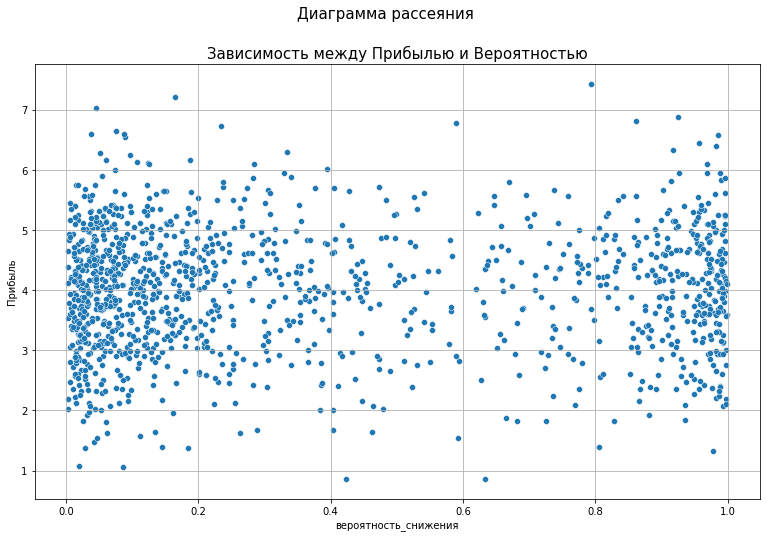

In [84]:
# найдём границу порога вероятности
plt.figure(figsize=[13,8])
plt.suptitle('Диаграмма рассеяния', fontsize = 15)
plt.title(f'Зависимость между Прибылью и Вероятностью', fontsize = 15)
sns.scatterplot(data = df_total, x = 'вероятность_снижения', y = 'Прибыль')
plt.grid(True)

Выбираем покупателей с высокой вероятностью отнесения к сегменту 1 (покупательская "снизилась") и низкой прибылью
- Исходя из графика, высокой вероятностью будем считать показатель >= 0.6, который чётко разграничивает признак
- Так же исходя из графика, высокой прибылью будем считать показатель >= 4, здесь просто поделим поровну

### Выделим сегмент покупателей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью

In [85]:
df_segment = df_total.query('вероятность_снижения >= 0.6 & Прибыль >= 4')
display(df_segment.head(5))
df_segment.shape

,id,Покупательская_активность,Тип_сервиса,Маркет_актив_6_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,траты_предыдущий_месяц,траты_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,прогноз,вероятность_снижения,Прибыль
0,215349,Снизилась,премиум,4.4,819,0.75,Товары для детей,4,4,2,5,5216.0,4971.6,12,10,Снизилась,0.659147,4.16
2,215351,Снизилась,стандарт,3.2,896,0.99,Товары для детей,5,0,6,4,6158.0,6610.4,11,13,Снизилась,0.797565,4.87
3,215352,Снизилась,стандарт,5.1,1064,0.94,Товары для детей,3,2,3,2,5807.5,5872.5,8,11,Снизилась,0.811114,4.21
9,215360,Снизилась,премиум,3.9,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5834.9,9,6,Снизилась,0.891797,4.55
36,215388,Снизилась,стандарт,3.5,663,0.99,Домашний текстиль,4,2,2,2,3188.0,3232.2,10,12,Снизилась,0.899744,5.16


(216, 18)

Выбрано 216 покупателей с высокой вероятностью снижения покупательской активности и высокой прибыльностью.

Рассмотрим наиболее значимые признаки:

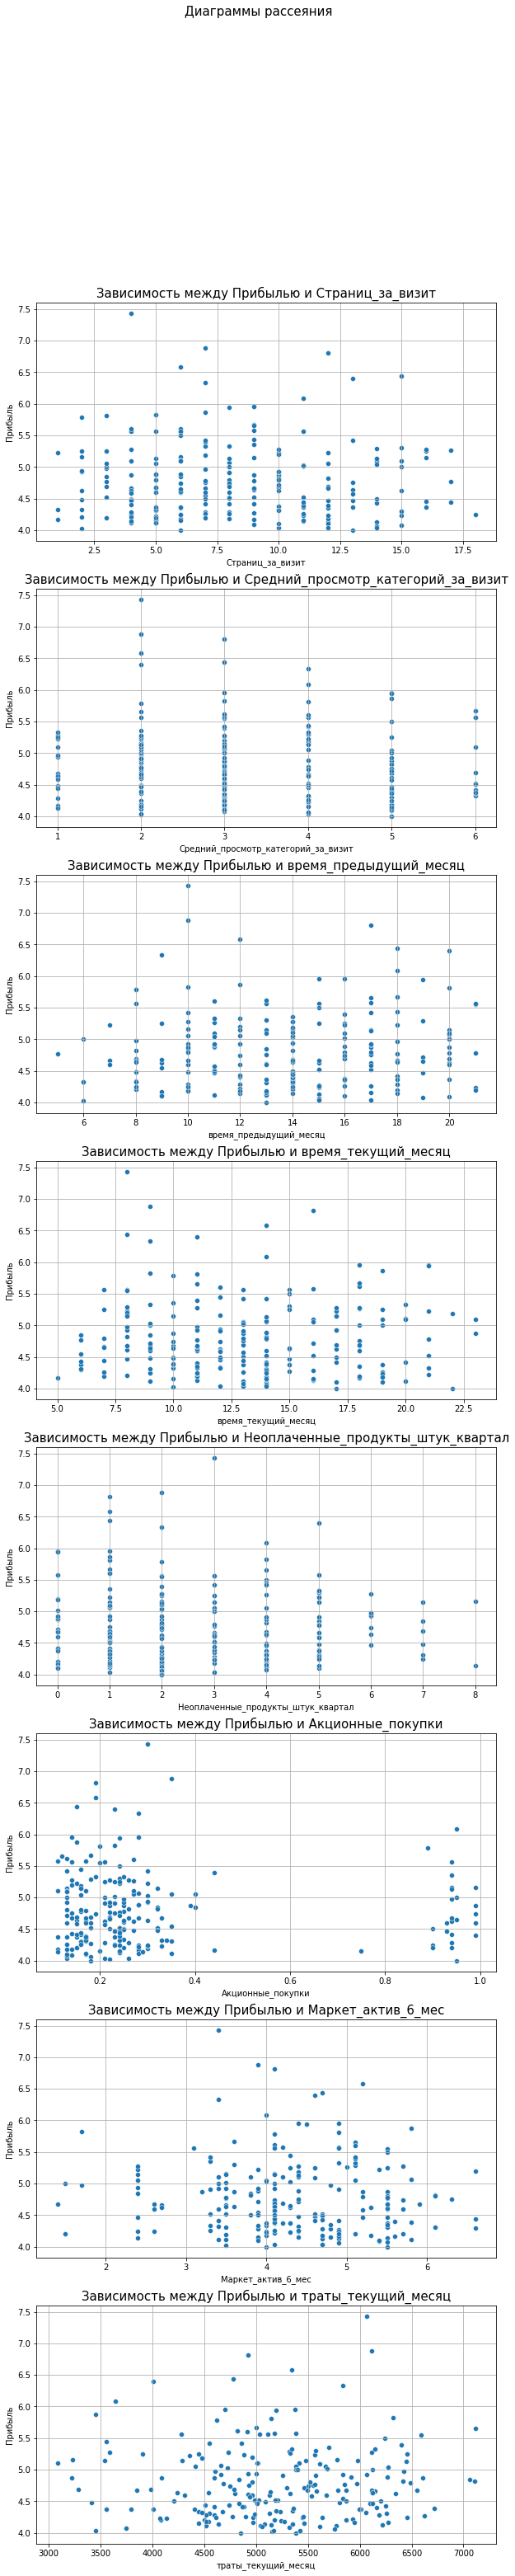

In [86]:
# построение диаграммы рассеяния scatterplot 
characteristics = ["Страниц_за_визит", "Средний_просмотр_категорий_за_визит", "время_предыдущий_месяц",
                   "время_текущий_месяц", "Неоплаченные_продукты_штук_квартал", "Акционные_покупки",
                   "Маркет_актив_6_мес", "траты_текущий_месяц"]
place = 0
plt.figure(figsize=[10,50])
plt.suptitle('Диаграммы рассеяния', fontsize = 15)
for char in characteristics:
    place += 1
    plt.subplot(8, 1, place)
    plt.title(f'Зависимость между Прибылью и {char}', fontsize = 15)
    sns.scatterplot(data = df_segment, x = char, y = 'Прибыль')
    plt.grid(True)

Явных корреляций не наблюдается ни по одному из признаков.

Можно посмотреть срение значения прибыли по разным значениям внутри признака.

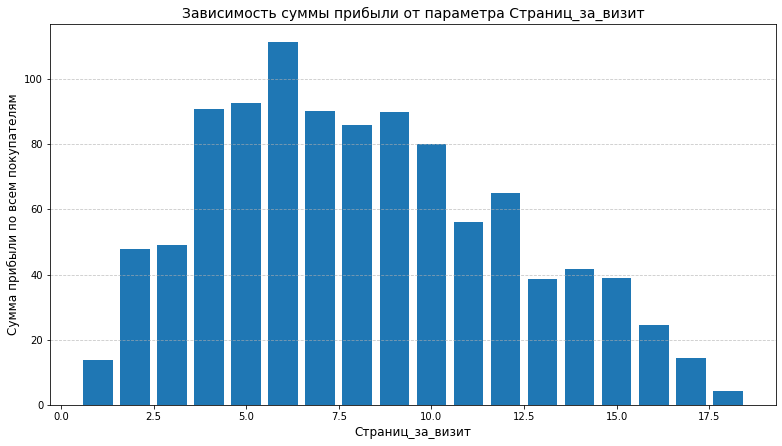

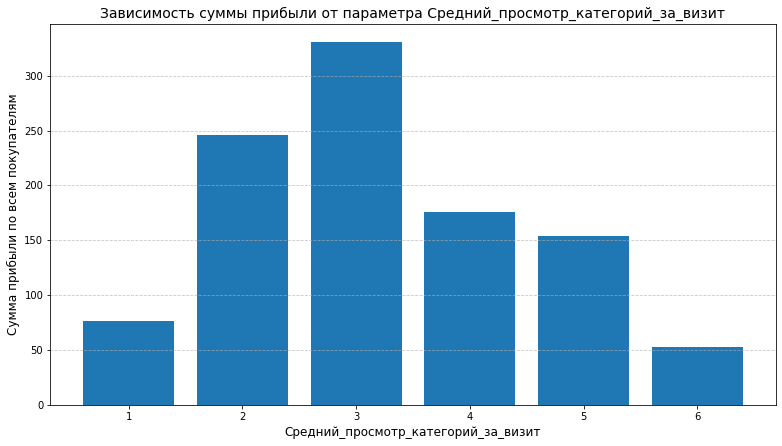

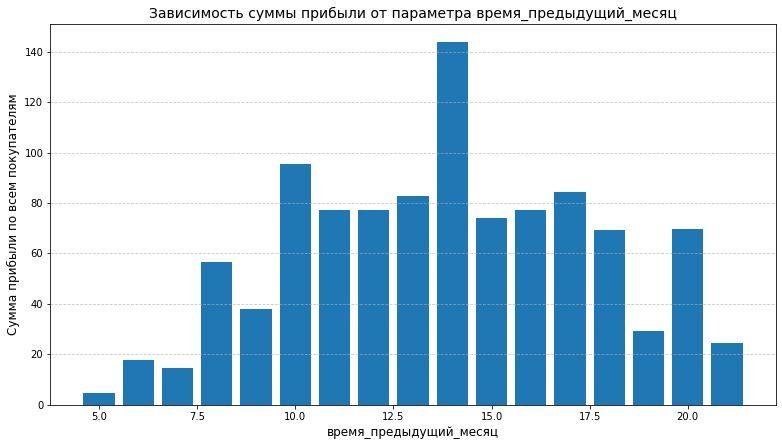

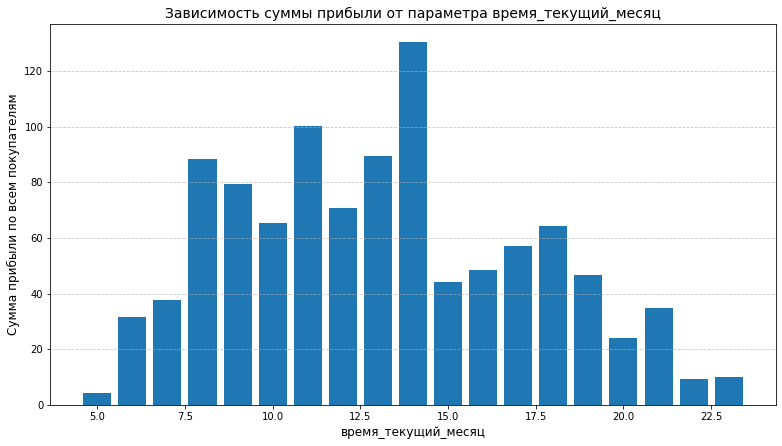

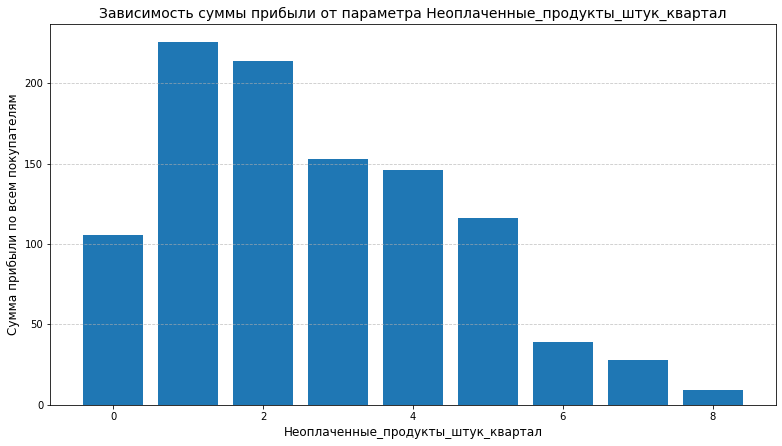

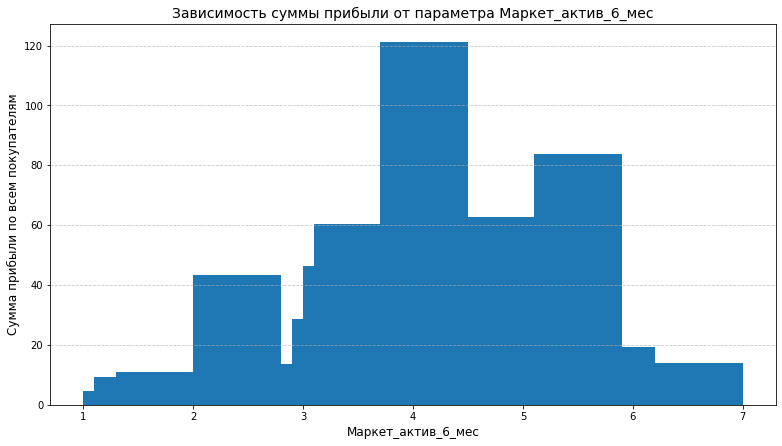

In [87]:
characteristics_for_sum = ["Страниц_за_визит", "Средний_просмотр_категорий_за_визит", "время_предыдущий_месяц",
                            "время_текущий_месяц", "Неоплаченные_продукты_штук_квартал", 
                            "Маркет_актив_6_мес"]

for char in characteristics_for_sum:
    
    grouped = df_segment.groupby(char)['Прибыль'].sum().reset_index()
    
    plt.figure(figsize=(13, 7)) 
    plt.bar(grouped[char], grouped['Прибыль'])

    plt.title(f'Зависимость суммы прибыли от параметра {char}', fontsize=14) 
    plt.xlabel(f'{char}', fontsize=12)  # Подпись оси X
    plt.ylabel('Сумма прибыли по всем покупателям', fontsize=12)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)  
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10)  

    plt.show()

- Исходя из первого графика "Зависимость суммы прибыли от параметра **Страниц_за_визит**", можно сделать вывод о том, что оптимальное количество страниц при посещении - 6. Если человек пролистывает меньше страниц, он не вовлекается, если больше 10, то его внимание рассеивается, и он не совершает покупку.
- График "Зависимость суммы прибыли от параметра **Средний_просмотр_категорий_за_визит**". Количество категорий, при котором суммарная прибыль от покупателей максимальна - 3. Вероятно, если человек обращает внимание на меньшее количество категорий, он не заинтересовывается, если на большее - отвлекается от покупки.
- "Зависимость суммы прибыли от параметра **время_предыдущий_месяц**". Опять же есть золотая середина, при которой наблюдается пик суммарной прибыли. График коррелирует с количеством просмотренных категорий, что закономерно, поскольку чем дольше покупатель находится на сайте (в приложении, сервисе), тем большее количество категорий он просмотрит.
- "Зависимость суммы прибыли от параметра **Неоплаченные_продукты_штук_квартал**" - довольно простое объяснение: чем больше неоплаченных продуктов, тем больше человек склонен экономить или ждать снижения цены. Неоплаченные продукты прибыль не приносят. Присутствует интересное явление - суммарная прибыль покупателей без неоплаченных покупок меньше иных с одним или даже пятью неоплаченными покупками. Здесь предположим, что такие пользователи изначально не имеют намерений производить покупку, а, например, сравнивают цены или *заходят в магазин просто так, чтобы быть в курсе* (как говорили в рекламе Компьютерного мира в начале нулевых).
- "Зависимость суммы прибыли от параметра **Маркет_актив_6_мес**" - здесь, как и в большинстве случаев, присутствует среднее максимальное значение суммарной прибыли. Вероятно, низкая активность негативно сказывается на интересе покупателя, а высокая, наоборот, отталкивает от ресурса.

## Общий вывод

### Описание поставленной задачи

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Описание исходных данных и проведённая предобработка

В качестве исходных данных представлен четыре таблицы:<br>
    - **market_file.csv**, содержащая  данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении<br>
    - **market_money.csv**, содержащая данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом<br>
    - **market_time.csv**, содержащая данные о времени (в минутах), которое покупатель провёл на сайте в течение периода<br>
    - **money.csv**, содержащая данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю

Проведена предобработка данных, включающая в себя поиск и устранение пропусков, явных и неявных дубликатов, приведение типа данных столбцов к корректному виду.

### Предпринятые действия для поиска лучшей модели

Для поиска лучшей модели был сформирован пайплайн, содержащий различные гиперпараметры, например: максимальную глубину в дереве решений, различные скейлеры и модели DecisionTreeClassifier(), KNeighborsClassifier(), LogisticRegression(), SVC(), различные ядра для модели SVC() и т.д.

### Лучшая модель

В результате отбора по методу **randomized_search** лучшей была признана модель **LogisticRegression** со следующими гиперпараметрами: *'preprocessor__num': StandardScaler(), 'models__C': 4, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')*.

По метрике roc-auc модель на тренировочной выборке показала значение 0.899, на тестовой - 0.917, что является хорошим результатом.
Метрика roc_auc выбрана как менее чувствительная к дисбалансу классов, а дисбаланс в целевом параметре мы наблюдаем.

### Общие выводы

Как показало исследование, наиболее значимыми признаками для оценки снижения покупательской способности являются в порядке убывания: количество страниц за визит, средний просмотр категорий за визит, время, проведенное на ресурсе в предыдущем месяце, аналогичное время в текущем месяце, количество неоплаченных продуктов за квартал, доля акционных покупок, маркетинговая активность за 6 месяцев, категория *мелкая бытовая техника и электроника*, траты в текущем месяце.<br>

Так же была произведена сегментация покупателей с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью. Анализ сегментированных данных показал, что необходимо вовлекать пользователя для того, чтобы он совершал больше покупок (приносил большую прибыль), но в то же время не задерживать его на ресурсе слишком долго, а целенаправленно подводить к покупке. Сделать это возможно, например, с помощью улучшения интерфейса, с помощью которого сократится количество шагов от поиска товара до покупки, либо погдотовить улучшенный алгоритм предлагающий товары, которые пользователь приобретёт с большей вероятностью. Так же необходимо соблюдать баланс маркетинговой активности, где оптимальным значением за 6 месяцев является 4 коммуникации.